In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_path = "data/prizes-1000.json"

with open(file_path, 'r') as file:
    data = json.load(file)

In [3]:
data['nobelPrizes'][0]

{'awardYear': '1901',
 'category': {'en': 'Chemistry', 'no': 'Kjemi', 'se': 'Kemi'},
 'categoryFullName': {'en': 'The Nobel Prize in Chemistry',
  'no': 'Nobelprisen i kjemi',
  'se': 'Nobelpriset i kemi'},
 'dateAwarded': '1901-11-12',
 'prizeAmount': 150782,
 'prizeAmountAdjusted': 10531894,
 'links': [{'rel': 'nobelPrize',
   'href': 'https://api.nobelprize.org/2/nobelPrize/che/1901',
   'action': 'GET',
   'types': 'application/json'}],
 'laureates': [{'id': '160',
   'knownName': {'en': "Jacobus H. van 't Hoff"},
   'fullName': {'en': "Jacobus Henricus van 't Hoff"},
   'portion': '1',
   'sortOrder': '1',
   'motivation': {'en': 'in recognition of the extraordinary services he has rendered by the discovery of the laws of chemical dynamics and osmotic pressure in solutions',
    'se': 'såsom ett erkännande av den utomordentliga förtjänst han inlagt genom upptäckten av lagarna för den kemiska dynamiken och för det osmotiska trycket i lösningar'},
   'links': [{'rel': 'laureate',
  

In [4]:
prize_data = []

In [5]:
# Need to exclude Peace and Literature prizes
for prize in data['nobelPrizes']:
    category = prize.get('category', {}).get('en')
    if category in ['Literature', 'Peace', 'Economic Sciences']:  # Exclude 'Literature' and 'Peace'
        continue
    laureates = prize.get('laureates')
    if laureates is None:
        continue

    prize_data.append({
        'category': category,
        'year': prize.get('awardYear'),
        'laureates': len(prize.get('laureates'))
    })

In [6]:
prize_df = pd.DataFrame(prize_data)

In [7]:
prize_df.head()

,category,year,laureates
0,Chemistry,1901,1
1,Physics,1901,1
2,Physiology or Medicine,1901,1
3,Chemistry,1902,1
4,Physics,1902,2


In [8]:
# Count the instances of each category
prize_df['category'].value_counts()

category
Physics                   117
Chemistry                 115
Physiology or Medicine    114
Name: count, dtype: int64

In [9]:
# Split the data by category and count the instances of 1, 2 and 3 in the laureates column
grouped_data = prize_df.groupby('category')['laureates'].value_counts().unstack().fillna(0)

In [10]:
grouped_data

laureates,1,2,3
category,,,
Chemistry,63,25,27
Physics,47,32,38
Physiology or Medicine,40,35,39


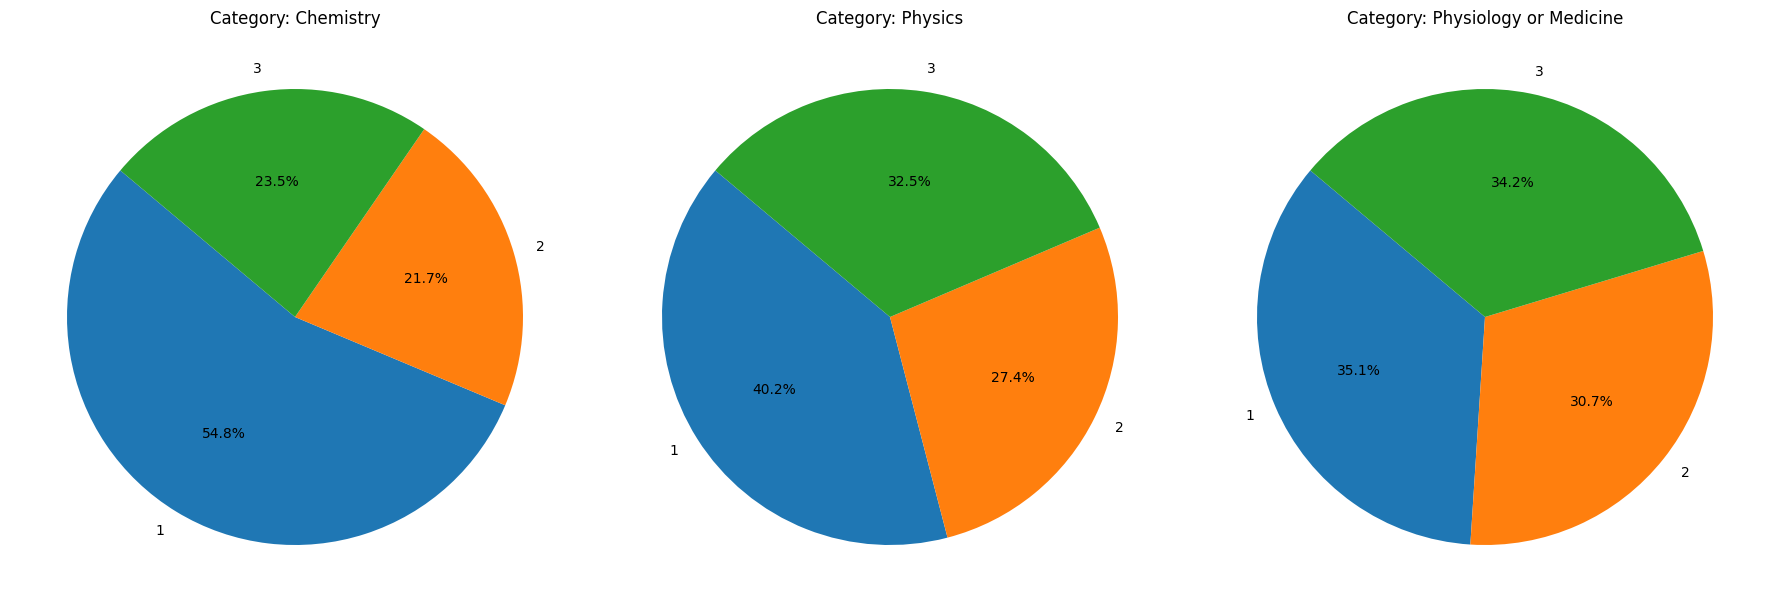

In [15]:
# Plot pie charts for each category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (category, counts) in zip(axes, grouped_data.iterrows()):
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Category: {category}')

plt.tight_layout()
plt.show()

In [23]:
prize_df[prize_df['category'] == 'Chemistry']['laureates']

0      1
3      1
6      1
9      1
12     1
      ..
331    3
334    2
337    2
340    3
343    3
Name: laureates, Length: 115, dtype: int64

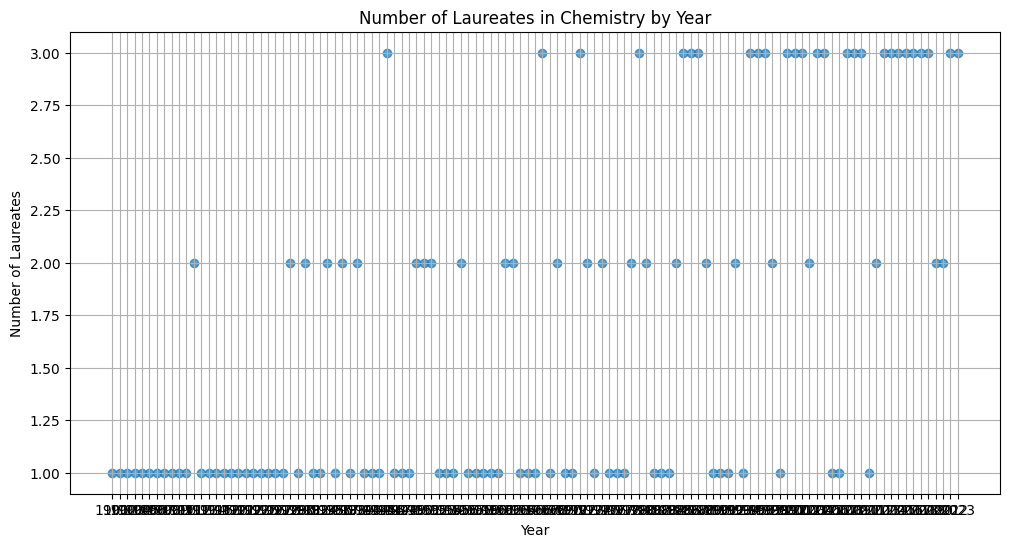

In [24]:
# Create a scatter plot for the number of laureates over the years
plt.figure(figsize=(12, 6))
plt.scatter(prize_df[prize_df['category'] == 'Chemistry']['year'], prize_df[prize_df['category'] == 'Chemistry']['laureates'], alpha=0.7)
plt.title('Number of Laureates in Chemistry by Year')
plt.xlabel('Year')
plt.ylabel('Number of Laureates')
plt.grid(True)
plt.show()

In [33]:
# For pize_df convert the year column to integers
prize_df['year'] = prize_df['year'].astype(int)



In [35]:
# For each category, in prize_df count the instances of 2 or 3 laureates per decade
prize_df['decade'] = prize_df['year'] // 10 * 10
grouped_data = prize_df[prize_df['laureates'] >= 2].groupby('category')['decade'].value_counts().unstack().fillna(0)

In [36]:
grouped_data

decade,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
category,,,,,,,,,,,,,
Chemistry,0.0,1.0,1.0,4.0,1.0,4.0,4.0,4.0,7.0,5.0,8.0,9.0,4.0
Physics,3.0,1.0,2.0,3.0,0.0,8.0,4.0,9.0,8.0,8.0,10.0,10.0,4.0
Physiology or Medicine,2.0,0.0,3.0,3.0,5.0,6.0,9.0,9.0,8.0,8.0,10.0,8.0,3.0


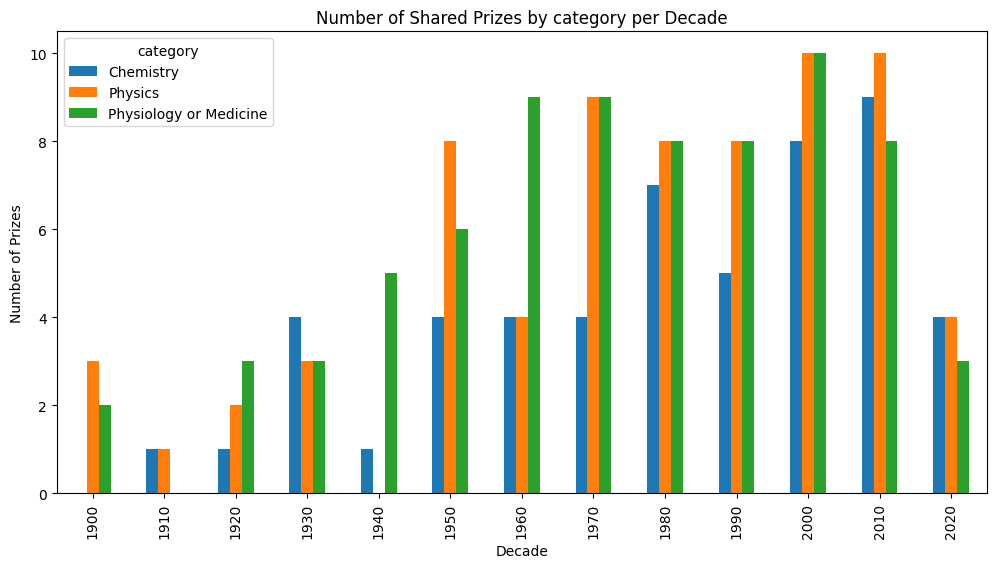

In [42]:
grouped_data.T.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Shared Prizes by category per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Prizes')
plt.show()